>## research paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

In [2]:
import torch
import torchvision
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print(f"helper_functions.py already exists, skipping download...")
else:
    print(f"downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)

helper_functions.py already exists, skipping download...


In [4]:
import helper_functions

image_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                               destination="pizza_steak_sushi",
                               remove_source=True)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
!git clone https://github.com/stanleyedward/pytorch_modules.git

fatal: destination path 'pytorch_modules' already exists and is not an empty directory.


In [7]:
from pytorch_modules.modules import data_preprocess
from torchvision import transforms
#create image size( table 3 of vit paper)
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])
print(f"manually creaated transforms: {manual_transforms}")

manually creaated transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
#craete a batchsize of 32 (even tho paper uses 4096 we dont have hardware for it)
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_preprocess.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [9]:
### visualize a single image
#get a batch of imge
image_batch, label_batch = next(iter(train_dataloader))
#get a single img and abel form the batch
image, label = image_batch[0], label_batch[0]

#view the abtch shapes
print(f"train_dataloader_batchshape: {image_batch.shape}")

#view the single img shape
image.shape, label

train_dataloader_batchshape: torch.Size([32, 3, 224, 224])


(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

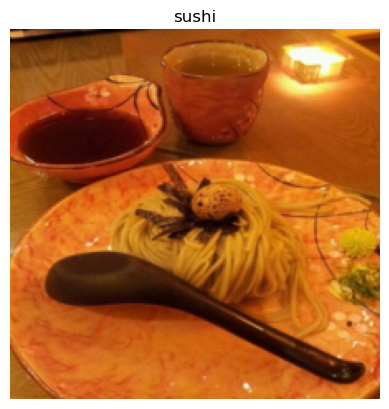

In [10]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) #as matplotlib takes CHW
plt.title(class_names[label])
plt.axis("off")

# overview of the paper
- figure 1: viual overview of the architecture
- four equations: math equations which define the function ofeach layer/block
- table 1/3: diffrente hyperparamters for the architecture/trianing.
- text

### figure 1
![Alt text](image-2.png)
* embedding - learnable representation (start with random numbers and improve them overtime) 
* mlp = multilevel perceptron



### four equations
![Alt text](image-1.png)

Equaion1:
* embedding - learnable representation (start with random numbers and improve them overtime) 
* path embeddings - patches of original image - pink
* position embeddings - to retain positional information -  purple
* class token embedding - to perform classification (*/pink)

```python
x_input = [learnable_class_token, image_patch_embeddings_1, image_patch_embeddings_2,...image_patch_embeddings_N]+
            [learnable_class_token_pos, image_patch_1_embeddings_pos, image_patch_2_embeddings_pos,...image_patch_N_embeddings_pos]
```

Equation2:
* MSA = Multi-Head self attention (Multi-Head Attension)
* LN = LayerNorm (Norm))
* zv(l-1) = input before LN block, adding residual connections (+)

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input 

```

Equation3:
* MLP = MultiLayer Perceptron
* LN = LayerNorm
* z'v(l) = input before LN block, adding residual connections (+)

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Equation4:
* MLP = MultiLayer Perceptron - a nerual network with x no. of layers
* MLP = one hidden layer at training time
* MLP = single linear layer in fine-tuning time
* LN = LayerNorm

```python
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```
or
```python
y = MLP(LN_layer(x_output_MLP_block)) 
```


### table 1/3:
![Alt text](image-3.png)

#### all different sizes of the same model
#### ViT-B/16 - ViT-Base with image patch size 16x16

* layers = no. of transformers encoder layers
* hidden size $D$  - the embedding size throughout the architecture

                    - if we have embedding size of 768 means 

                    - each image patch that may be 16x16 

                    - is turned into a vector of size 768

                    - learnable vector*
                    
* MLP size - no. of hidden units/neurons in the MLP

            - if the MLP size is 3072 
            - then the no of hidden units in the MLP layer in 3072

* Heads - the number of heads within multihead self-attention layers

        - if heads = 12 we have 12 heads in MSA layer
        
> ![Alt text](image-4.png)
        
        - denoted by h



### text

## equatinon1: split data into patches and creating the class, position and patch embedding 

### layers = input -> function -> output 

* what's the input shape?
* whats the output shape?

one of the biggest porblems in dl are misaligned tensor shapes

* Input shape: (224,224) -> single image -> (height, width, color channels)
* Output shape: 

* Input shape: $H*W*C$ [hieight,width, color channels]
* output shape: $N\times(P^2*C)$
- H = height
- W = width
- C = Color channels
- P = patchs ize
- N = number of patches = (height*width)/p^2
- D =  constant latent vector size = embedding dimension (see table 1)

In [11]:
# exmaple values 
height = 224
width = 224
color_channels = 3
patch_size = 16

#calc the number of patches
num_patches = int((height *width) / (patch_size**2)) 
num_patches

196

In [12]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

#otput shape
embedding_layer_output_shape = (num_patches, patch_size**2 * color_channels)

print(f"input shape( single@D iamge): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of pathces): {embedding_layer_output_shape}")

input shape( single@D iamge): (224, 224, 3)
Output shape (single 1D sequence of pathces): (196, 768)


* Input shape: (224,224) -> single image -> (height, width, color channels)
* Output shape: (196,768) -> (number of patches, embedding_dimension)   ; embedding dimension = $D$ from table 1

## turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

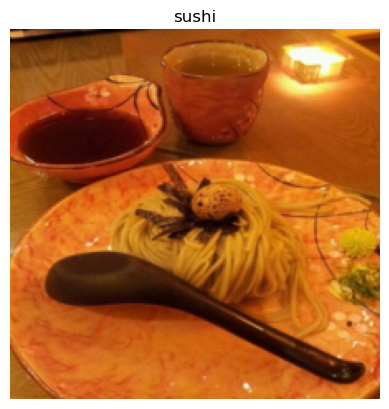

In [13]:
#view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off")

In [14]:
image.shape

torch.Size([3, 224, 224])

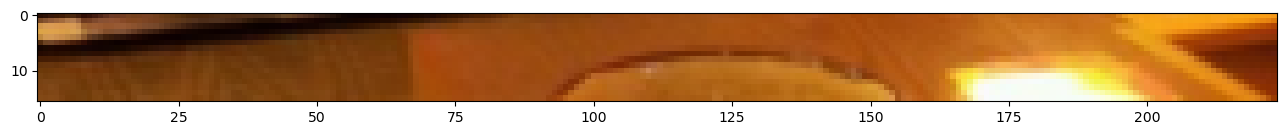

In [24]:
#get the top row of the image
image_permuted = image.permute(1,2,0) #HWC for matplotlib

#index to plot the top row of pixels
patch_size = 16 #from paper
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
 Patch size:16 x 16 pixels
0 0
1 16
2 32
3 48
4 64
5 80
6 96
7 112
8 128
9 144
10 160
11 176
12 192
13 208


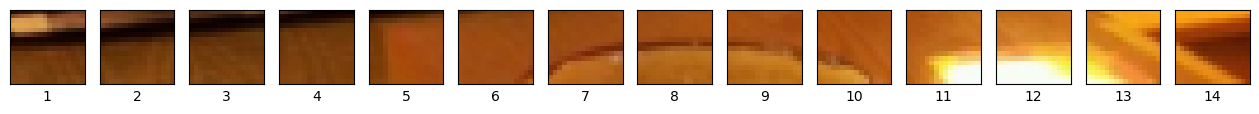

In [34]:
#setup code t oplot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisble by patch size"
print(f"Number of patches per row: {num_patches}\n Patch size:{patch_size} x {patch_size} pixels")
#create a series of subplots
fig, axis = plt.subplots(nrows=1,
                         ncols=img_size// patch_size, #one column for each patch
                         sharex=True,
                         sharey=True,
                         figsize = (patch_size,patch_size)
)

#iterate thorugh the patches in the top row 
for i, patch in enumerate(range(0,img_size, patch_size)): #from 0 to img_size with step of patchsize 
    print(i,patch)
    axis[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axis[i].set_xlabel(i+1)
    axis[i].set_xticks([])
    axis[i].set_yticks([])
    

Number of parches per row: 14.0    
Number of patches per column: 14.0        
Patch size: 16 x 16 pixels


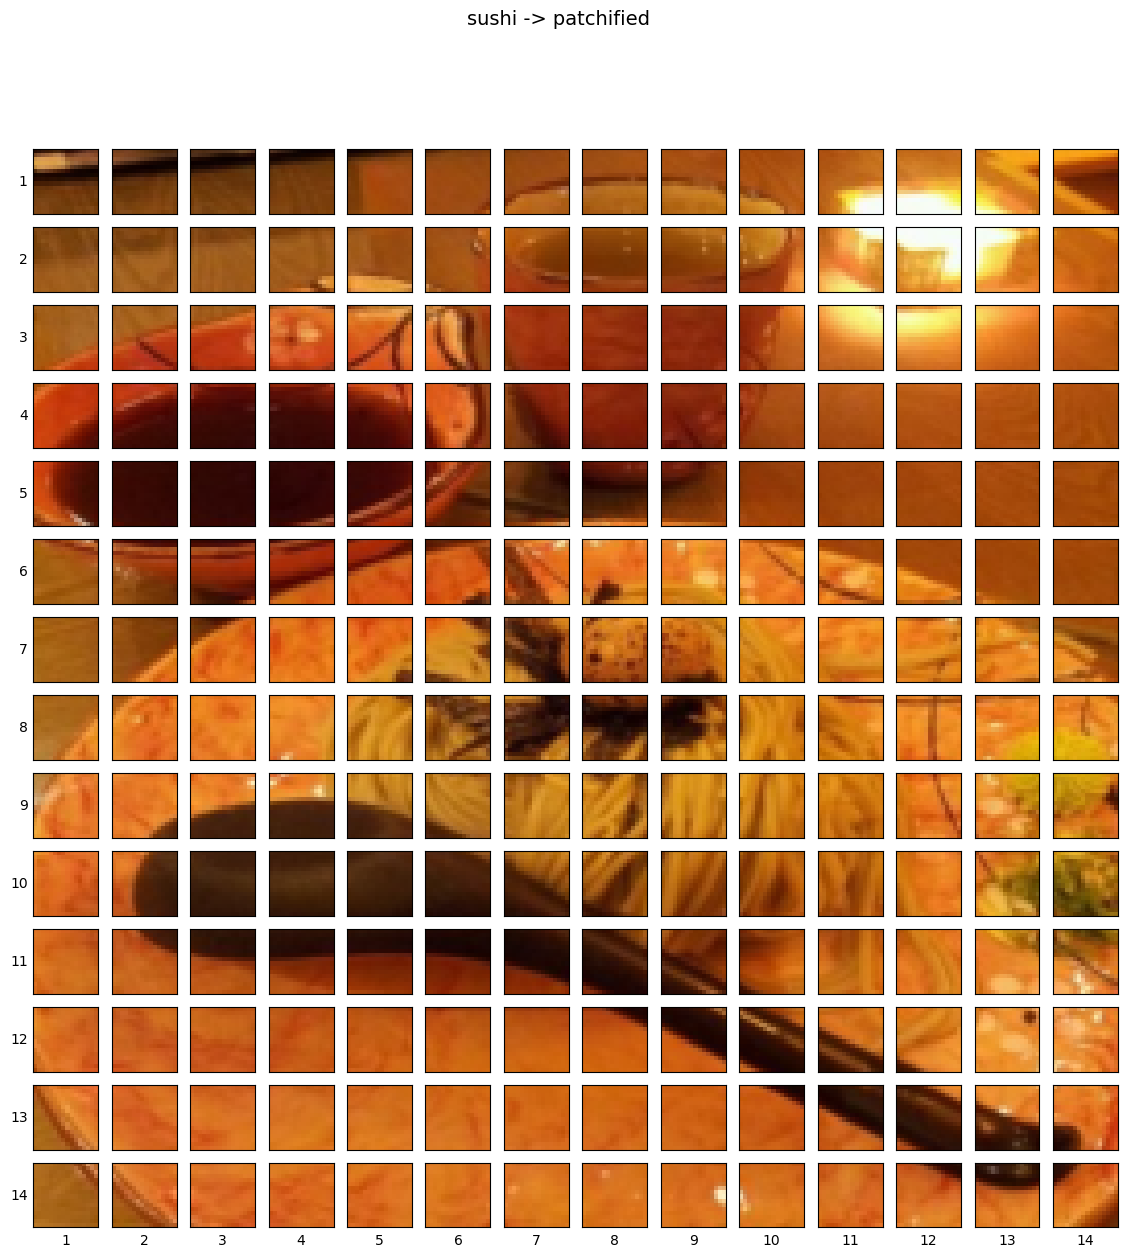

In [45]:
#plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "image size must be divisble by patch size"
print(f"Number of parches per row: {num_patches}\
    \nNumber of patches per column: {num_patches}\
        \nPatch size: {patch_size} x {patch_size} pixels")

# craete a series of subplots 
fig, axis = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         figsize=(num_patches,num_patches),
                         sharex=True,
                         sharey=True)

#loop thuough the height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        #plot the permuted img o n the diffrent axes
            # print(i,j,patch_height, patch_width)
            axis[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, #iterate through height
                                             patch_width:patch_width+patch_size, #iterante though width
                                             :])#get all color channels
            axis[i, j].set_ylabel(i+1,
                                  rotation="horizontal",
                                  horizontalalignment="right",
                                  verticalalignment="center")
            axis[i, j].set_xlabel(j+1)
            axis[i, j].set_xticks([])
            axis[i, j].set_yticks([])
            axis[i ,j].label_outer()
#set up the title fo rth plot
fig.suptitle(f"{class_names[label]} -> patchified", fontsize=18)
plt.show()

In [48]:
14*14 #patches

196

## creating image patches and turning them into patch embeddings

* perhaps we could create the image patches and imge patch embedding ina  single step using 
`torch.nn.Conv2d()` and setting the kernel size and stride to `patch_size`.
- a convolutinal feature map is a laernable representation or `an embedding`

In [49]:
#create conv2d layer to turn image into patches of learnable feature mas (embeddings))
from torch import nn
#set the patchpisze
patch_size = 16
#create a conv2d layers with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, #D size from table 1 for ViT-Base, embedding size
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

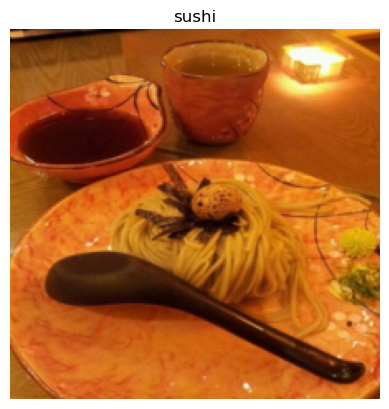

In [50]:
#view single image
plt.title(class_names[label])
plt.imshow(image.permute(1,2,0))
plt.axis(False)

In [51]:
#paass the image thorugh the conv layer
image_out_of_conv = conv2d(image.unsqueeze(0)) #batchdimension  -> [batchsize, color channels, hieght, width]
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [53]:
14*14 #number of patchsizes WE NEED TO FLATTEN

196

Now we've passed a single image into our conv2d layers we got 
```python
torch.Size([1, 768, 14, 14]) # [batchsize, embedding_dim, feature_map_height, feature_map_width]
```

In [54]:
image_out_of_conv

tensor([[[[ 3.0923e-02,  2.1126e-02,  2.4624e-02,  ...,  1.1212e-02,
            1.3514e-01, -9.0414e-02],
          [ 2.8064e-02,  4.7938e-02,  4.9055e-02,  ...,  3.0558e-01,
            1.0958e-01,  7.3899e-02],
          [ 8.4988e-02,  6.7596e-02,  1.1106e-01,  ...,  2.2086e-01,
            1.0728e-01,  5.8131e-02],
          ...,
          [ 5.4241e-02,  7.7682e-02,  7.0304e-02,  ...,  1.7182e-01,
            7.8856e-02,  9.1168e-02],
          [ 1.6154e-01,  1.0370e-01,  1.0602e-01,  ...,  1.3258e-01,
            2.0314e-01,  1.7750e-01],
          [ 7.6317e-02,  1.9863e-01,  1.0845e-01,  ..., -6.0926e-02,
            5.6181e-02,  9.6695e-02]],

         [[ 2.8962e-02,  2.6167e-02, -2.0749e-02,  ...,  1.3452e-02,
           -6.3497e-02, -1.2946e-01],
          [-1.7847e-02, -5.8080e-04, -1.4806e-02,  ...,  2.1741e-01,
            6.3570e-02, -5.9603e-02],
          [ 1.0291e-02, -3.2144e-02, -1.9973e-02,  ...,  1.0233e-01,
           -4.0788e-02, -4.2533e-02],
          ...,
     

In [56]:
image_out_of_conv.requires_grad

True

showing random convolutional feature maps from indexes: [273, 28, 498, 365, 460]


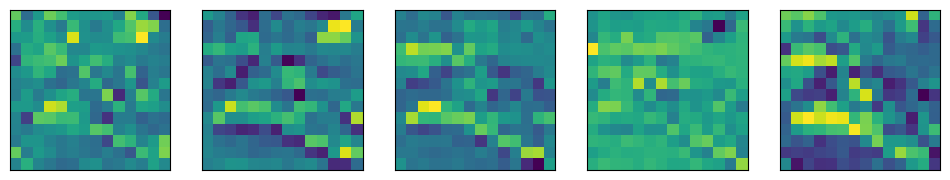

In [68]:
#plot random conv feature maps (embeddings)
import random
random_indexes = random.sample(range(0,768), k=5)
print(f"showing random convolutional feature maps from indexes: {random_indexes}")

# cretea a plot
fig, axis = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(12,12)
)

#plot rnadom image feature maps
for i, index in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, index, :, :]# index on the output tensor of the conv2d layer
    axis[i].imshow(image_conv_feature_map.squeeze().detach().numpy())#remove batch dim #remove from grad tracking/ switch to numpy for matplotlib
    axis[i].set(
        xticklabels=[],
        yticklabels=[],
        xticks=[],
        yticks=[]
    )

In [63]:
#get a single feature map in tensor form 
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad, single_feature_map.shape


(tensor([[[ 0.0309,  0.0211,  0.0246, -0.0433,  0.0552,  0.0653, -0.0068,
            0.0730,  0.0615,  0.0465,  0.0412,  0.0112,  0.1351, -0.0904],
          [ 0.0281,  0.0479,  0.0491,  0.0891, -0.0155,  0.0636,  0.0041,
            0.0335,  0.0973,  0.1714,  0.2233,  0.3056,  0.1096,  0.0739],
          [ 0.0850,  0.0676,  0.1111,  0.1003,  0.1821, -0.0549,  0.0456,
            0.0248,  0.0179,  0.1978,  0.2821,  0.2209,  0.1073,  0.0581],
          [ 0.0164,  0.0556,  0.0061,  0.0222,  0.0989, -0.0480,  0.0616,
            0.0384,  0.0834,  0.1028,  0.0948,  0.0846,  0.0578,  0.0716],
          [-0.1681, -0.0243, -0.0192, -0.0342, -0.0029,  0.0303, -0.0838,
           -0.0731, -0.0226,  0.0257,  0.0565,  0.0699,  0.0531,  0.0601],
          [ 0.1223,  0.0429,  0.0559, -0.0147,  0.0483,  0.0673,  0.2583,
            0.2014,  0.1468,  0.0348,  0.0996,  0.0671,  0.0384,  0.0527],
          [ 0.0527,  0.0516,  0.1056,  0.1126,  0.1126, -0.0209,  0.0909,
            0.2127,  0.1920,  0.

## flattening the patch embedding/ feature map with torch.nn.flatten
right now we've got a series of conv faeture maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satusfy the criteria of the
ViT 

In [69]:

print(f"{image_out_of_conv.shape} -> [batch_size, embeddingdim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embeddingdim, feature_map_height, feature_map_width]


### went [batch_size, num_of_patches, embeddingdim]

In [71]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, 
                           end_dim=3)
flatten_layer(image_out_of_conv).shape #the order is still not w

torch.Size([1, 768, 196])

### order is still not correct

Originval image shape: torch.Size([3, 224, 224])
image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape : torch.Size([1, 768, 196])


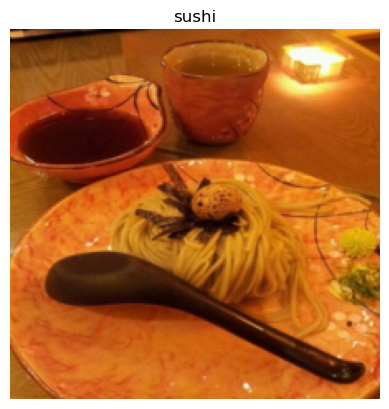

In [72]:
#put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Originval image shape: {image.shape}")

#turn image into faeture maps
image_out_of_conv = conv2d(image.unsqueeze(0))#add batch dim
print(f"image feature map (patches) shape: {image_out_of_conv.shape}")

#flatten the faeture maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape : {image_out_of_conv_flattened.shape}")

In [73]:
#rearrage output of flattened layer
print(f"{image_out_of_conv_flattened.permute(0,2,1).shape} ->[batchsize, num of patches, embedding dimension]")

torch.Size([1, 196, 768])